In [73]:
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

from base.pandas_constants import AlgorithmConstants, DataFrameConstants


In [74]:
df = read_csv(AlgorithmConstants.FINAL_DF_PATH)
df.head()

df = df[df[DataFrameConstants.DANGER_LEVEL] != 'Baixa']

In [75]:
df.describe()

,processo_numero,latitude,longitude,rain_day,rain_hour,elevation
count,1.927000e+03,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,8.049312e+09,-8.034787,-34.930820,15.314634,0.658018,47.235599
std,1.863672e+07,0.052360,0.017891,19.046952,1.286009,16.238344
min,8.000042e+09,-8.140337,-34.979501,0.000000,0.000000,7.000000
25%,8.034528e+09,-8.086452,-34.945819,3.650000,0.100000,35.000000
50%,8.053231e+09,-8.009220,-34.929010,9.600000,0.200000,47.000000
75%,8.061411e+09,-8.000093,-34.917472,19.100000,0.600000,60.000000
max,8.113660e+09,-7.961544,-34.886717,83.000000,8.300000,90.000000


In [76]:
label_encoders = {}
categorical_columns = [
    DataFrameConstants.GROUND_TYPE,
    DataFrameConstants.GROUND_AMPLITUDE,
    DataFrameConstants.SLOPE_DEGREE,
    DataFrameConstants.SLOPE_PERCENTAGE,
    DataFrameConstants.DANGER_LEVEL
]

numerical_columns = [
    DataFrameConstants.RAIN_DAY,
    DataFrameConstants.RAIN_HOUR,
    DataFrameConstants.ELEVATION,
    DataFrameConstants.LATITUDE,
    DataFrameConstants.LONGITUDE
]

df_encoded = df.copy()

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

df_encoded = df_encoded[numerical_columns + categorical_columns]
df_encoded.describe()

,rain_day,rain_hour,elevation,latitude,longitude,ground_type,ground_amplitude,slope_degree,slope_percentage,danger_level
count,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,15.314634,0.658018,47.235599,-8.034787,-34.930820,2.319668,1.970420,0.981318,1.970420,0.901401
std,19.046952,1.286009,16.238344,0.052360,0.017891,1.480066,0.175489,0.195122,0.175489,0.298200
min,0.000000,0.000000,7.000000,-8.140337,-34.979501,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.650000,0.100000,35.000000,-8.086452,-34.945819,2.000000,2.000000,1.000000,2.000000,1.000000
50%,9.600000,0.200000,47.000000,-8.009220,-34.929010,3.000000,2.000000,1.000000,2.000000,1.000000
75%,19.100000,0.600000,60.000000,-8.000093,-34.917472,3.000000,2.000000,1.000000,2.000000,1.000000
max,83.000000,8.300000,90.000000,-7.961544,-34.886717,5.000000,2.000000,2.000000,2.000000,1.000000


In [77]:
best_k = 0
best_inertia = None
best_columns = None
best_config = None

range_clusters = list(range(1, 30))
random_states = list(range(0, 64))

max_iters = [300, 500, 1000]
algorithms = ['lloyd', 'elkan']
best_k_means = None

In [78]:
scaler = StandardScaler()


df_to_be_scaled = df_encoded
df_scaled = scaler.fit_transform(df_to_be_scaled)

DataFrame(df_scaled).describe()


,0,1,2,3,4,5,6,7,8,9
count,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03
mean,1.474920e-17,-1.474920e-17,-1.843650e-18,-3.731548e-15,5.092014e-13,1.327428e-16,-1.253682e-16,-3.097332e-16,-1.253682e-16,5.899680e-17
std,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00
min,-8.042552e-01,-5.118072e-01,-2.478457e+00,-2.016389e+00,-2.721776e+00,-1.567680e+00,-1.123107e+01,-5.030572e+00,-1.123107e+01,-3.023591e+00
25%,-6.125737e-01,-4.340270e-01,-7.536960e-01,-9.869897e-01,-8.386258e-01,-2.160383e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
50%,-3.001067e-01,-3.562469e-01,-1.451260e-02,4.884230e-01,1.011687e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
75%,1.987903e-01,-4.512622e-02,7.862694e-01,6.627827e-01,7.462511e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
max,3.554529e+00,5.943946e+00,2.634228e+00,1.399199e+00,2.465748e+00,1.811425e+00,1.685992e-01,5.222112e+00,1.685992e-01,3.307325e-01


In [79]:
SSE = []
results = []

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    kmeans.fit(df_scaled)
    inertia = kmeans.inertia_
    SSE.append(inertia)
    print(f'Inertia: {inertia}')
    if best_inertia is None or inertia < best_inertia:
        best_k = num_clusters
        best_k_means = kmeans
        best_inertia = kmeans.inertia_

print(f'Best K: {best_k}, Best Inertia: {best_inertia}')

Inertia: 19269.999999999996
Inertia: 16451.54435135474
Inertia: 11275.705116987492
Inertia: 9646.479277950235
Inertia: 7922.805963108078
Inertia: 7376.1261038257035
Inertia: 5931.592091524251
Inertia: 5667.162506034352
Inertia: 5097.9610759467
Inertia: 4963.471746398354
Inertia: 4720.0819306082285
Inertia: 4170.2622259528525
Inertia: 4156.550183450691
Inertia: 3926.48998834893
Inertia: 3528.6039075681283
Inertia: 3487.944358943055
Inertia: 3390.732068847223
Inertia: 3269.8294855204135
Inertia: 3174.321390458909
Inertia: 3042.7607586188524
Inertia: 2936.5065996049016
Inertia: 2880.6711855902513
Inertia: 2680.796097705349
Inertia: 2665.0095756407163
Inertia: 2594.1955443500683
Inertia: 2629.4788051403966
Inertia: 2492.80839416045
Inertia: 2453.8550379597445
Inertia: 2304.2685101599736
Best K: 29, Best Inertia: 2304.2685101599736


Text(0, 0.5, 'Inertia')

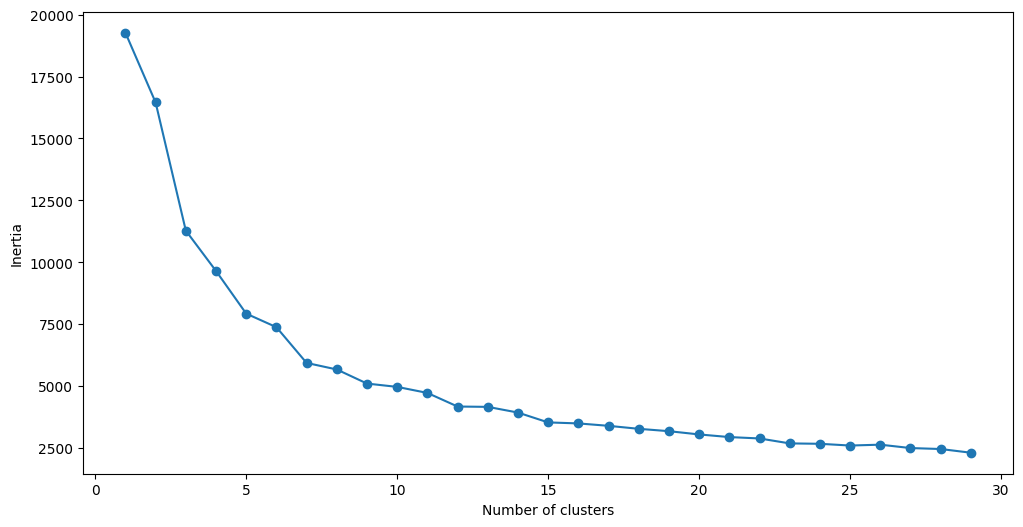

In [80]:
frame = DataFrame({'Cluster':range(1, 30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


In [81]:
kmeans = KMeans(n_clusters=8, init='k-means++') # Using elbow curve
kmeans.fit(df_scaled)
print(f'Inertia: {kmeans.inertia_}')   
pred = kmeans.predict(df_scaled)

Inertia: 5673.477361866113


In [82]:
df[DataFrameConstants.CLUSTER] = pred

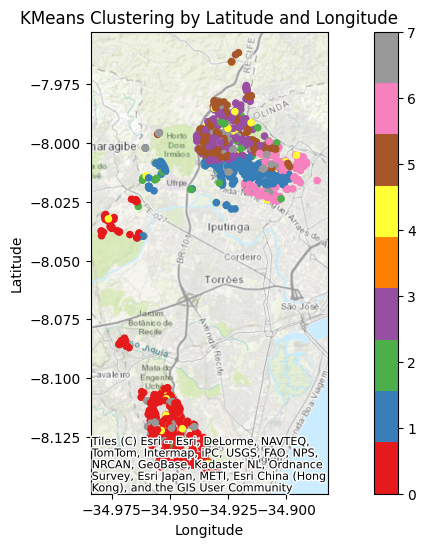

In [83]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[DataFrameConstants.LONGITUDE], df[DataFrameConstants.LATITUDE])
)

# Set a CRS (Coordinate Reference System) for the GeoDataFrame (e.g., WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Plotting with map background
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the GeoDataFrame on the ax
gdf.plot(ax=ax, column=DataFrameConstants.CLUSTER, cmap='Set1', markersize=20, legend=True)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldTopoMap)

# Customize plot appearance
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('KMeans Clustering by Latitude and Longitude')

plt.show()


In [84]:
df.to_csv('kmeans.csv', index=False, header=True)

In [85]:
df.head()

,processo_numero,latitude,longitude,ground_type,ground_amplitude,slope_degree,slope_percentage,danger_level,rain_day,rain_hour,elevation,cluster
1,8031386621,-7.998090,-34.921421,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,3.8,1.0,23.0,3
2,8033507521,-8.116982,-34.951488,LVd2,20 a 100m,10 a 30º,0 a 60%,Media,10.3,0.2,51.0,0
5,8030622821,-8.004813,-34.908961,URBANO,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,43.0,6
6,8030708021,-8.002648,-34.908863,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.6,0.6,53.0,5
7,8030626321,-8.001664,-34.903260,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,25.0,6
